In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chaospy
import pathlib
from pathlib import Path  
from statistics import NormalDist

# Local packages
import optionpricing
from optionpricing import OptionPricingClass

# Settings
%load_ext autoreload
%autoreload 2

# Parent folder for saved data/figures
pf = pathlib.Path().resolve() # Points to parent folder containing notebook and data, eg: 'C:/Users/Carla/Dropbox/Uni/10. Semester/Dynamic Programming/Term paper'

# Plots & Tables

## Section: Replication

### Comparison of simulation results to the results of Longstaff and Schwartz

In [2]:
# For term paper
basis_func = 'laguerre'
simulations = '100000'

paper_results = pd.read_csv(f'{pf}/data/LS_table2.csv') # results from LSM paper
df = pd.read_csv(f'{pf}/data/Table2_{basis_func}_{simulations}.csv') # simulation results
df = pd.concat([df, paper_results], axis=1) # combined
df['diff in price'] = df['price']-df['ls_price']
df = df.drop(['time elapsed'],axis=1)
# To latex
print(df.to_latex(index=False, float_format="%.3f")) #

\begin{tabular}{rrrrrrrr}
\toprule
 S0 &  sigma &     T &  price &   s.e &  ls\_price &  ls\_s.e. &  diff in price \\
\midrule
 36 &  0.200 & 1.000 &  4.490 & 0.009 &     4.472 &    0.010 &          0.018 \\
 36 &  0.200 & 2.000 &  4.842 & 0.011 &     4.821 &    0.012 &          0.021 \\
 36 &  0.400 & 1.000 &  7.115 & 0.019 &     7.091 &    0.020 &          0.024 \\
 36 &  0.400 & 2.000 &  8.515 & 0.022 &     8.488 &    0.024 &          0.027 \\
 38 &  0.200 & 1.000 &  3.253 & 0.009 &     3.244 &    0.009 &          0.009 \\
 38 &  0.200 & 2.000 &  3.741 & 0.011 &     3.735 &    0.011 &          0.006 \\
 38 &  0.400 & 1.000 &  6.156 & 0.019 &     6.139 &    0.019 &          0.017 \\
 38 &  0.400 & 2.000 &  7.671 & 0.022 &     7.669 &    0.022 &          0.002 \\
 40 &  0.200 & 1.000 &  2.320 & 0.009 &     2.313 &    0.009 &          0.007 \\
 40 &  0.200 & 2.000 &  2.886 & 0.010 &     2.879 &    0.010 &          0.007 \\
 40 &  0.400 & 1.000 &  5.313 & 0.018 &     5.308 &    0.018 & 

### Choice of polynomial

In [3]:
results = pd.read_csv(f'{pf}/data/Choice_of_poly_{simulations}.csv')
print(results.to_latex(index=True, float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  polyfit &  chebyshev &  laguerre &  hermite &  legendre \\
\midrule
0 &    4.414 &      4.414 &     4.414 &    4.414 &     4.414 \\
1 &    4.429 &      4.429 &     4.429 &    4.429 &     4.429 \\
2 &    4.431 &      4.431 &     4.431 &    4.431 &     4.431 \\
3 &    4.459 &      4.459 &     4.459 &    4.459 &     4.459 \\
4 &    4.457 &      4.457 &     4.457 &    4.457 &     4.457 \\
5 &    4.467 &      4.467 &     4.467 &    4.467 &     4.467 \\
6 &    4.474 &      4.474 &     4.474 &    4.474 &     4.474 \\
7 &    4.472 &      4.472 &     4.472 &    4.472 &     4.472 \\
\bottomrule
\end{tabular}



## Section: Brownian Bridge

In [4]:
map_to_norm = lambda u: NormalDist(mu=0, sigma=1).inv_cdf(u)
map_to_norm_f = np.vectorize(map_to_norm)

def halton_draws(n):
    
    nodes = chaospy.create_halton_samples(n, dim=1, burnin=- 1).flatten()
    
    # Storage for uniform draws within Halton node bins
    
    draws = map_to_norm_f(nodes)
    
    return draws

# Illustrate brownian bridge

# Parameters 
np.random.seed(150)
r = 0.06
S0 = 100
sigma = 0.3
T = 1 # end time
M = 5 # Paths
N = 100 # number of time steps
dt = T / N

# Initial and final draw

W_0 = 0
W = np.random.normal(0, 1, size = M)

# Initial and final stock price

S_0 = np.empty(shape=(M)) # one column per sim
S_0.fill(S0)

# starting points #

# independent draws
S_T = S_0 * np.exp((r - 1/2 * sigma**2)*T + np.sqrt(T)*sigma * W) 

#Halton draws
W_halton = halton_draws(M)

S_T_Halton = S_0 * np.exp((r - 1/2 * sigma**2)*T + np.sqrt(T)*sigma * W_halton) 

# construct prices

S = S_T
S_Halton = S_T_Halton

for t in range(N-1, -1, -1):

    # Generate new draw

    eps = np.random.normal(0, 1, size = (M))
    
    eps_halton = np.random.normal(0, 1, size = (M))
    
    W_t = t/(t+1) * W + np.sqrt(t/(t+1)*dt) * eps
    
    W_Halton_t = t/(t+1) * W_halton + np.sqrt(t/(t+1)*dt) * eps_halton
    
    dW_t = W_t - W_0
    dW_Halton_t = W_Halton_t - W_0
    
    # Generate current stock price

    S_t = S_0 * np.exp((r - 1/2 * sigma**2)*t*dt + sigma * dW_t)
    
    S_halton_t = S_0 * np.exp((r - 1/2 * sigma**2)*t*dt + sigma * dW_Halton_t)
    
    S = np.vstack([S,S_t]) # save stock price for plotting purpose
    S_Halton = np.vstack([S_Halton,S_halton_t]) # save stock price for plotting purpose
    
    # save W for next iteration

    W = W_t
    W_halton = W_Halton_t
    
S = np.vstack([S])
S = np.flip(S)

S_Halton = np.vstack([S_Halton])
S_Halton = np.flip(S_Halton)

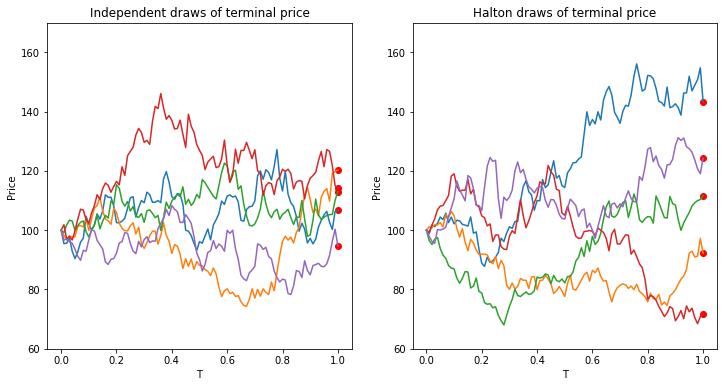

In [5]:
x = np.linspace(0,1,num = N+1,endpoint = True,retstep = False,dtype = None)

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.set_title('Independent draws of terminal price')
ax.plot(x, S, label='Independent')
ax.scatter(np.ones(M), S_T, color = "red")
ax.set_ylim([60, 170])
ax.set_xlabel("T")
ax.set_ylabel("Price")

ax2.set_title('Halton draws of terminal price')
ax2.plot(x, S_Halton, label='Halton')
ax2.scatter(np.ones(M), S_T_Halton, color = "red")
ax2.set_ylim([60, 170])
ax2.set_xlabel("T")
ax2.set_ylabel("Price")

#plt.savefig('Brownian_bridge_example.pdf')
plt.show()

## Section: Performance

In [6]:
# read these simulation data:
basis_func = 'laguerre'
M_range = range(10, 210, 20) 

# fixed
reference_values = (10.726486710094511, 4.820608184813253, 1.828207584020458) # TRUE OPTION VALUES

### Squared errors

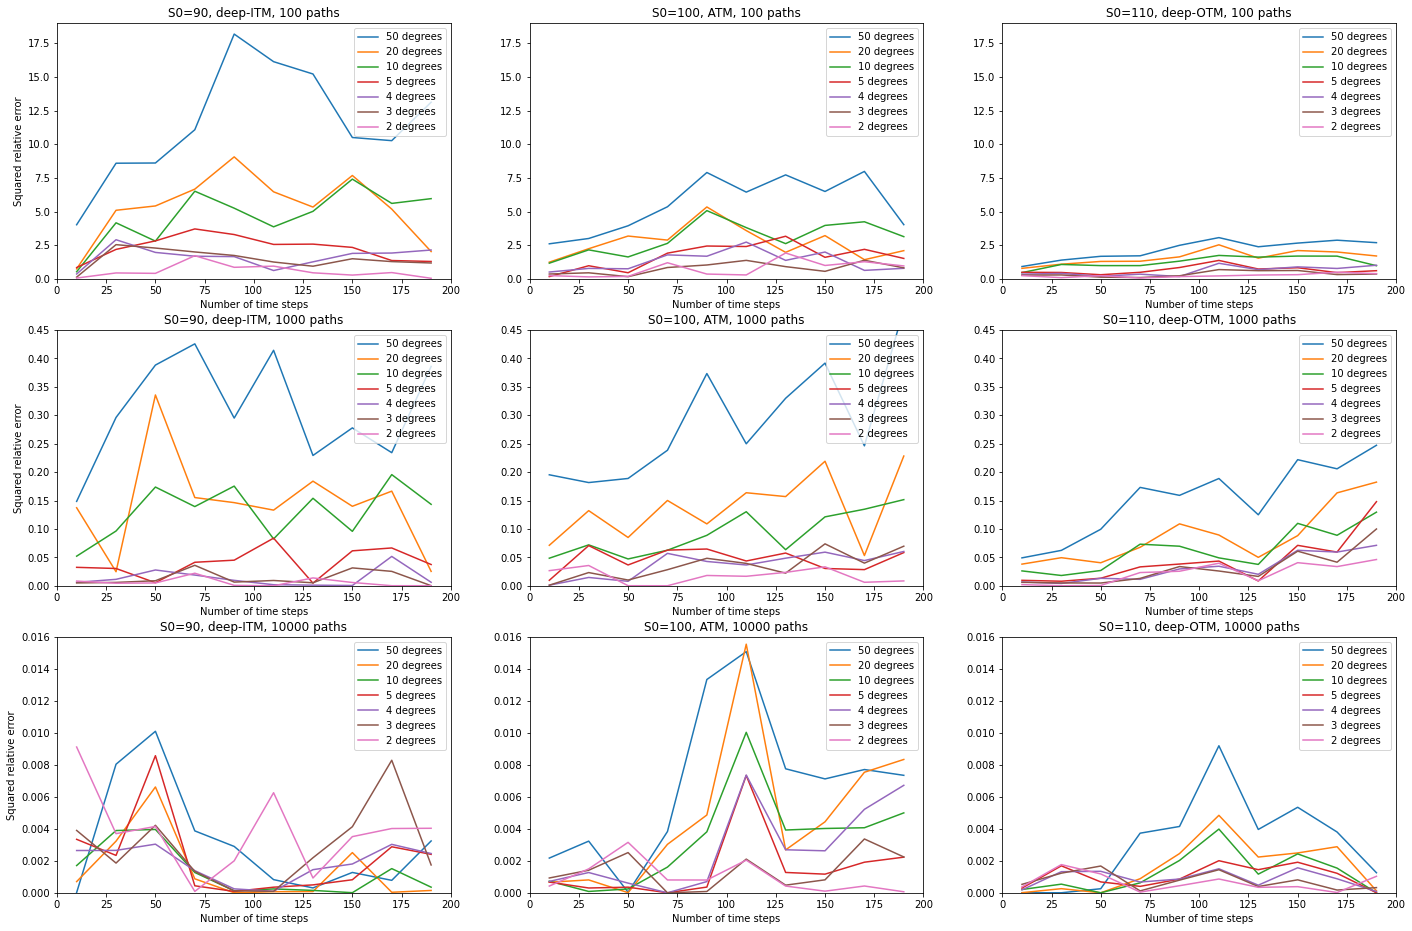

In [7]:
# plot: 6 plots max
rows = (0, 0, 0, 1, 1, 1, 2, 2, 2)
cols = (0, 1, 2, 0, 1, 2, 0, 1, 2)
S0s = (90, 100, 110, 90, 100, 110, 90, 100, 110) # vary between these 3
plot_sim = (100, 100, 100, 1000, 1000, 1000, 10000, 10000, 10000)
prefvalues = (10.726486710094511, 4.820608184813253, 1.828207584020458, 10.726486710094511, 4.820608184813253, 1.828207584020458, 10.726486710094511, 4.820608184813253, 1.828207584020458)
titles = ['deep-ITM', 'ATM', 'deep-OTM', 'deep-ITM', 'ATM', 'deep-OTM', 'deep-ITM', 'ATM', 'deep-OTM']
plot_pars = zip(rows, cols, S0s, titles, plot_sim, prefvalues)

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(3, 3, figsize=(24,16))

# Plot each axis
for i, par in enumerate(plot_pars): 
    #print(f'i={i}, row={par[0]}, col{par[1]}')
    S0 = par[2] # set S0
    
    # set x values
    X = M_range #df['M'] 
    
    for deg in (50, 20, 10, 5, 4, 3, 2):
        # read data and filter based on S0 and degrees
        df = pd.read_csv(f'{pf}/data/accuracy_{basis_func}_{len(M_range)}Ms_{par[4]}sims.csv') # read simulation results
        df = df[df['S0'] == S0] # Select S0
        df = df[df['degrees'] == deg] # Select degree
        df = df[df['basis func'] == basis_func] # Select degree
        df = df[df['simulations'] == par[4]] # Select degree
        #df = df[df['basis func'] == basis_func] # bf
        
        # set y values
        Y = df['rel. error'] # squared error
        
        # plot
        axis[par[0], par[1]].plot(X, Y), #color='black')
        axis[par[0], par[1]].set_title(f'S0={S0}, {par[3]}, {par[4]} paths')
    
    # labels etc
    if i in (0, 3, 6):
        axis[par[0], par[1]].set_ylabel(f'Squared relative error')
    axis[par[0], par[1]].set_xlabel(f'Number of time steps')
    
    # limits
    axis[par[0], par[1]].set_xlim(0,200)
    #axis[par[0]].set_yscale('log')
    
    if i in (0, 1, 2):
        axis[par[0], par[1]].set_ylim(0, 19)
    if i in (3, 4, 5):
        axis[par[0], par[1]].set_ylim(0, 0.45)
    if i in (6, 7, 8):
        axis[par[0], par[1]].set_ylim(0, 0.016)
    
    # legend
    axis[par[0], par[1]].legend(['50 degrees','20 degrees','10 degrees','5 degrees', '4 degrees', '3 degrees', '2 degrees'], loc='upper right')

filepath = Path(f'{pf}/data/PLOT_accuracy_errors_{basis_func}_{len(M_range)}Ms_Varyingsims') # Set name
plt.savefig(filepath, bbox_inches='tight')

### Time elapsed (log scale)

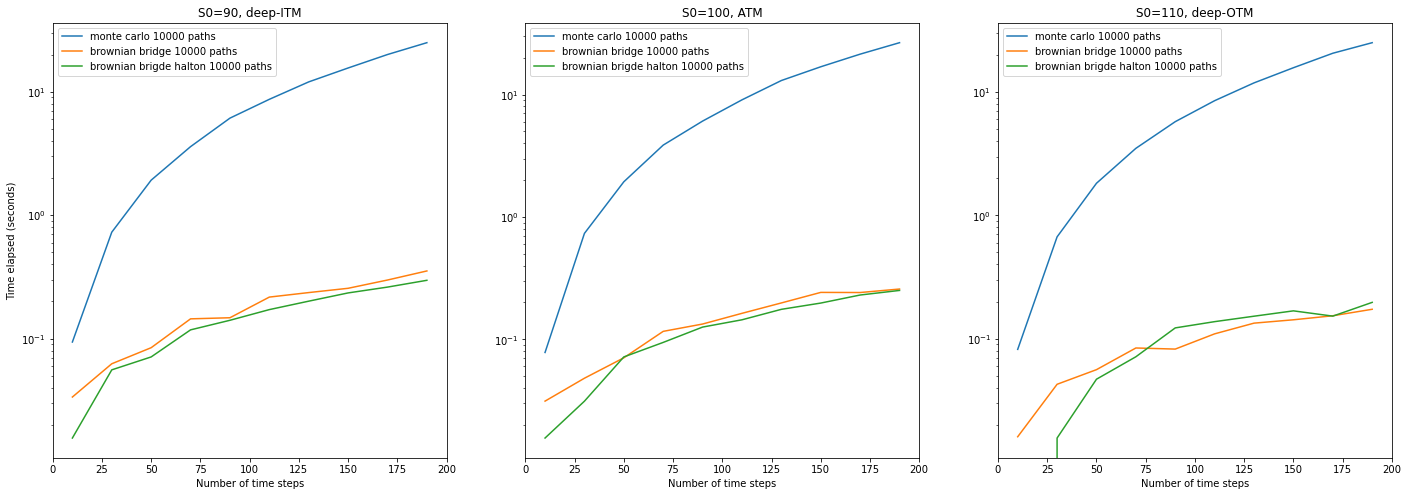

In [8]:
simulations = 10000

# plot: 6 plots max
rows = 0, 1, 2 #, 1 #, 2, 2
cols = 0, 1, 0 #, 1 #, 0, 1
S0s = (90, 100, 110) # vary between these 3
titles = ['deep-ITM', 'ATM', 'deep-OTM']
plot_pars = zip(rows,cols, S0s, titles)
deg = 5


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(24,8))

# Plot each axis
for i, par in enumerate(plot_pars): 
    S0 = par[2] # set S0

    # set x values
    X = M_range #df['M'] 
    
    ### Monte carlo
    # read data and filter based on S0 and degrees
    df = pd.read_csv(f'{pf}/data/accuracy_{basis_func}_{len(M_range)}Ms_{simulations}sims.csv') # read simulation results
    df = df[df['S0'] == S0] # Select S0
    df = df[df['degrees'] == deg] # Select degree
    df = df[df['basis func'] == basis_func] # bf

    # set y values
    Y = df['time elapsed'] # squared error

    # plot
    axis[par[0]].plot(X, Y), #color='black')
    axis[par[0]].set_title(f'S0={S0}, {par[3]}')
    
    ### Brownian bridge
    for halton in (True, False):
        df = pd.read_csv(f'{pf}/data/accuracy_BB_{basis_func}_{len(M_range)}Ms_{simulations}sims.csv') # read simulation results
        df = df[df['S0'] == S0] # Select S0
        df = df[df['degrees'] == deg] # Select degree
        df = df[df['halton'] == halton] # Select degree
        df = df[df['simulations'] == simulations] # Select degree
        

        # set y values
        Y = df['time elapsed'] # squared error

        # plot
        axis[par[0]].plot(X, Y), #color='black')
    
    # labels etc
    if i == 0:
        axis[par[0]].set_ylabel(f'Time elapsed (seconds)')
    axis[par[0]].set_xlabel(f'Number of time steps')
    axis[par[0]].set_xlim(0,200)
    
    # log scale
    axis[par[0]].set_yscale('log')
    
    # legend
    axis[par[0]].legend([f'monte carlo {simulations} paths', f'brownian bridge {simulations} paths', f'brownian brigde halton {simulations} paths'], loc='upper left')

filepath = Path(f'{pf}/data/PLOT_accuracy_time_{basis_func}_{len(M_range)}Ms_{simulations}sims') # Set name
plt.savefig(filepath, bbox_inches='tight')

### Squared errors with brownian bridge halton

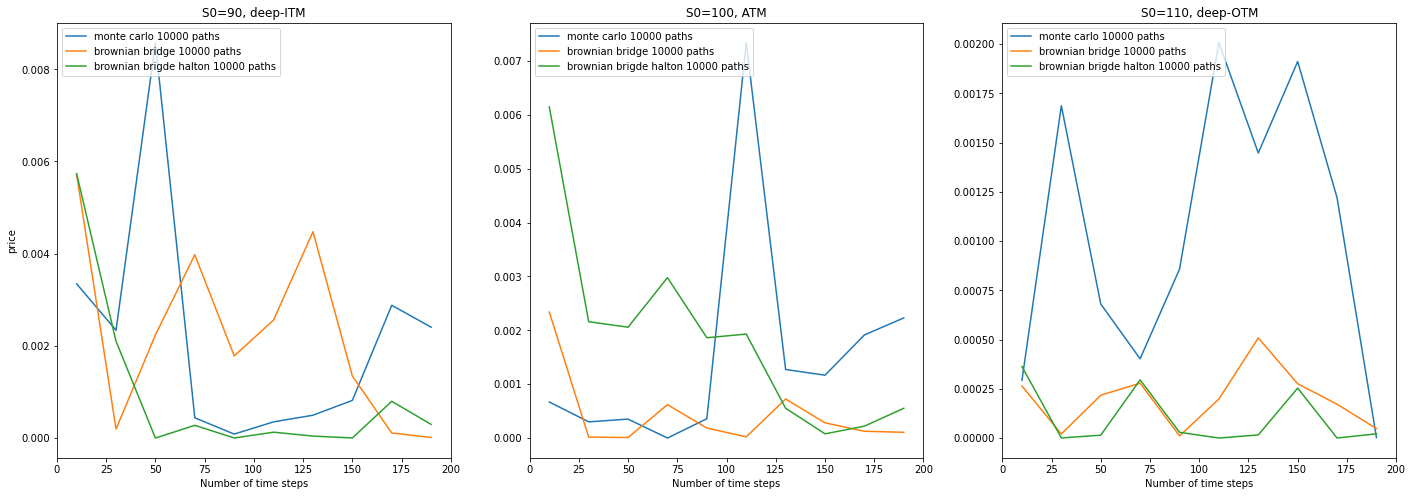

In [9]:
# plot: 6 plots max
rows = 0, 1, 2 #, 1 #, 2, 2
cols = 0, 1, 0 #, 1 #, 0, 1
S0s = (90, 100, 110) # vary between these 3
titles = ['deep-ITM', 'ATM', 'deep-OTM']
plot_pars = zip(rows,cols, S0s, titles)


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(24,8))

# Plot each axis
for i, par in enumerate(plot_pars): 
    S0 = par[2] # set S0

    # set x values
    X = M_range #df['M'] 
    
    ### Monte carlo
    # read data and filter based on S0 and degrees
    df = pd.read_csv(f'{pf}/data/accuracy_{basis_func}_{len(M_range)}Ms_{simulations}sims.csv') # read simulation results
    df = df[df['S0'] == S0] # Select S0
    df = df[df['degrees'] == deg] # Select degree
    df = df[df['basis func'] == basis_func] # bf

    # set y values
    Y = df['rel. error']# df['price'] # squared error

    # plot
    axis[par[0]].plot(X, Y), #color='black')
    axis[par[0]].set_title(f'S0={S0}, {par[3]}')
    
    ### Brownian bridge
    for halton in (True, False):
        df = pd.read_csv(f'{pf}/data/accuracy_BB_{basis_func}_{len(M_range)}Ms_{simulations}sims.csv') # read simulation results
        df = df[df['S0'] == S0] # Select S0
        df = df[df['degrees'] == deg] # Select degree
        df = df[df['halton'] == halton] # Select degree
        df = df[df['simulations'] == simulations] # Select degree

        # set y values
        Y = df['rel. error'] #df['price'] # squared error

        # plot
        axis[par[0]].plot(X, Y), #color='black')
    
    # labels etc
    if i == 0:
        axis[par[0]].set_ylabel(f'price')
    axis[par[0]].set_xlabel(f'Number of time steps')
    axis[par[0]].set_xlim(0,200)
    
    # Add true value
    #axis[par[0]].axhline(y=reference_values[i], color='blue', linestyle='--')#,  linewidth=0.5) # true value, need to select correct one based on s0
    
    # legend
    axis[par[0]].legend([f'monte carlo {simulations} paths', f'brownian bridge {simulations} paths', f'brownian brigde halton {simulations} paths', 'true'], loc='upper left')
    

filepath = Path(f'{pf}/data/PLOT_accuracy_values_{basis_func}_{len(M_range)}Ms_{simulations}sims') # Set name
plt.savefig(filepath, bbox_inches='tight')

### Matching compute time: squared errors with brownian brigdge halton

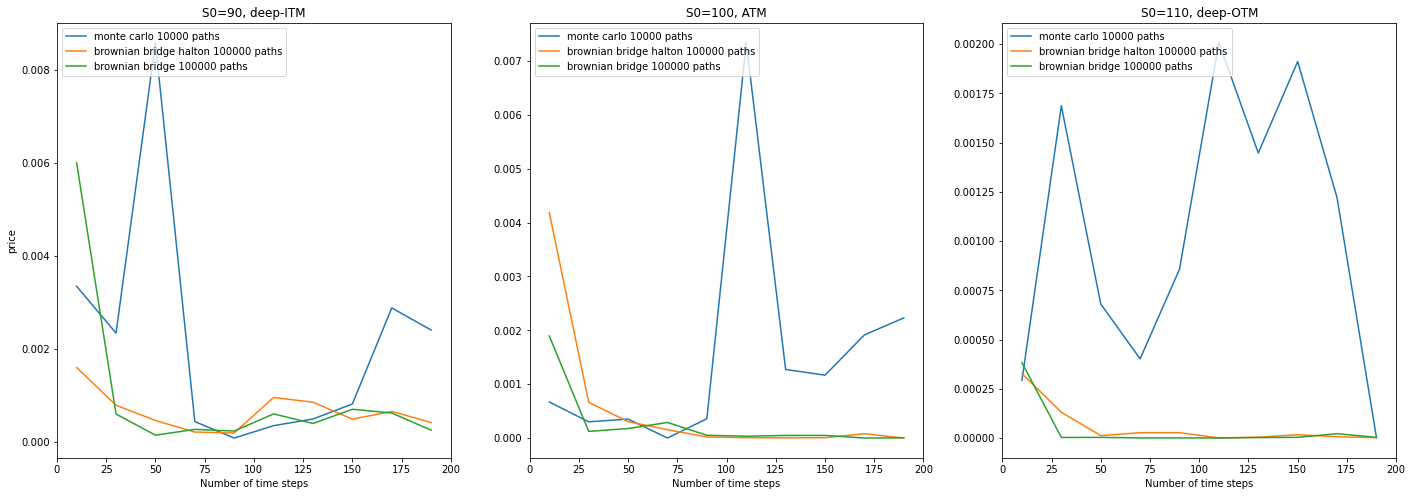

In [10]:
# plot: 6 plots max
rows = 0, 1, 2 #, 1 #, 2, 2
cols = 0, 1, 0 #, 1 #, 0, 1
S0s = (90, 100, 110) # vary between these 3
titles = ['deep-ITM', 'ATM', 'deep-OTM']
plot_pars = zip(rows,cols, S0s, titles)
simulations_BBmatch = 100000

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(24,8))

# Plot each axis
for i, par in enumerate(plot_pars): 
    S0 = par[2] # set S0

    # set x values
    X = M_range #df['M'] 
    
    ### Monte carlo
    # read data and filter based on S0 and degrees
    df = pd.read_csv(f'{pf}/data/accuracy_{basis_func}_{len(M_range)}Ms_{simulations}sims.csv') # read simulation results
    df = df[df['S0'] == S0] # Select S0
    df = df[df['degrees'] == deg] # Select degree
    df = df[df['basis func'] == basis_func] # bf

    # set y values
    Y = df['rel. error'] # df['price'] # squared error

    # plot
    axis[par[0]].plot(X, Y, label=f'monte carlo {simulations} paths'), #color='black')
    axis[par[0]].set_title(f'S0={S0}, {par[3]}')
    
    ### Brownian bridge
    #for sim in (simulations, simulations_BBmatch):
    for halton in (True, False):
        df = pd.read_csv(f'{pf}/data/accuracy_BB_{basis_func}_{len(M_range)}Ms_{simulations_BBmatch}sims.csv') # read simulation results
        df = df[df['S0'] == S0] # Select S0
        df = df[df['degrees'] == deg] # Select degree
        df = df[df['halton'] == halton] # Select degree
        df = df[df['simulations'] == simulations_BBmatch] # Select degree

        # set y values
        Y = df['rel. error'] #df['price'] # squared error

        # plot
        if halton == True:
            label = f'brownian bridge halton {simulations_BBmatch} paths'
        if halton == False:
            label = f'brownian bridge {simulations_BBmatch} paths'

        axis[par[0]].plot(X, Y, label=label), #color='black')
    
    # labels etc
    if i == 0:
        axis[par[0]].set_ylabel(f'price')
    axis[par[0]].set_xlabel(f'Number of time steps')
    axis[par[0]].set_xlim(0,200)
    
    # Add true value
    #axis[par[0]].axhline(y=reference_values[i], color='blue', linestyle='--', label='true')#,  linewidth=0.5) # true value, need to select correct one based on s0
    
    # legend
    axis[par[0]].legend(loc='upper left')
    

filepath = Path(f'{pf}/data/PLOT_accuracy_matched_values_{basis_func}_{len(M_range)}Ms_{simulations}sims') # Set name
plt.savefig(filepath, bbox_inches='tight')